# Data Analysis of BLM losses using a Peak Finder 

## Authors

- Benedict Rochmankowski
- Jonah Panting
- Mukta Burde


## Goals 
- Research methods of identifying peaks in a BLM signal
- Implement methods to analyse a given R5IM signal and identify the N largest losses

## Research

We researched and identified a few methods for peak detection. 
We tried out four methods:
- Scipy's find_peaks function (takes in width, height threshold parameters etc.)
- Scipy's prominence function
- Peakutils
- Regression / Base line with threshold height, and length (samples or time)
    1. Length thresholding ((n from left, n from right) >= threshold or modified threshold)
    2. Definite Integration ((limits are n from left to n from left, threshold area))
    
We then decided to use...

### Dependencies

In [48]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Scipy libraries
from scipy.signal import find_peaks
from scipy.signal import savgol_filter
from scipy import stats

User can change the DFI (Dataframe Index) inorder to switch between different BLMs.

In [49]:
DFI = 5

### Data Retrieval

In [50]:
files = glob.glob("BLM_R5IM_Data/cycle" + '/*.csv')

In [51]:
 for file in files:
    print(file) 

BLM_R5IM_Data/cycle\26_05_2023_00_35_36_034042.csv
BLM_R5IM_Data/cycle\26_05_2023_00_35_36_926089.csv
BLM_R5IM_Data/cycle\26_05_2023_00_35_38_236517.csv
BLM_R5IM_Data/cycle\26_05_2023_00_35_39_115167.csv
BLM_R5IM_Data/cycle\26_05_2023_00_35_39_949234.csv
BLM_R5IM_Data/cycle\26_05_2023_00_35_41_013048.csv
BLM_R5IM_Data/cycle\26_05_2023_00_35_42_031331.csv
BLM_R5IM_Data/cycle\26_05_2023_00_35_43_025596.csv
BLM_R5IM_Data/cycle\26_05_2023_00_35_44_019355.csv
BLM_R5IM_Data/cycle\26_05_2023_00_35_45_049643.csv
BLM_R5IM_Data/cycle\26_05_2023_00_35_45_987319.csv
BLM_R5IM_Data/cycle\26_05_2023_00_35_48_010611.csv
BLM_R5IM_Data/cycle\26_05_2023_00_35_48_369257.csv
BLM_R5IM_Data/cycle\26_05_2023_00_35_49_086323.csv
BLM_R5IM_Data/cycle\26_05_2023_00_35_50_079591.csv
BLM_R5IM_Data/cycle\26_05_2023_00_35_51_063682.csv
BLM_R5IM_Data/cycle\26_05_2023_00_35_52_020982.csv
BLM_R5IM_Data/cycle\26_05_2023_00_35_53_032674.csv


In [52]:
selected_file = files[0]

In [53]:
 input_data = pd.read_csv(selected_file)
dataframe = input_data.drop(columns = input_data.columns[0]).to_numpy()

In [54]:
dataframe

array([[-4.99939013e+00, -4.99939013e+00, -4.99939013e+00, ...,
        -4.99939013e+00, -4.99939013e+00, -4.99939013e+00],
       [-6.70999987e-03, -4.87999991e-03, -4.26999992e-03, ...,
        -5.48999989e-03, -4.87999991e-03, -4.26999992e-03],
       [-3.04999994e-03,  6.09999988e-04,  1.21999998e-03, ...,
         4.26999992e-03,  4.26999992e-03,  6.09999988e-04],
       ...,
       [-3.04999994e-03,  1.21999998e-03,  2.43999995e-03, ...,
         2.43999995e-03, -1.21999998e-03,  0.00000000e+00],
       [-1.21999998e-03, -1.21999998e-03,  6.09999988e-04, ...,
        -6.70999987e-03, -4.87999991e-03, -4.87999991e-03],
       [ 3.53999995e-02,  3.53999995e-02,  3.60100009e-02, ...,
         2.31899992e-02,  2.31899992e-02,  2.31899992e-02]])

In [55]:
x_data = np.linspace(-0.5, 10.5, 2200)
print(x_data)

[-0.5        -0.49499773 -0.48999545 ... 10.48999545 10.49499773
 10.5       ]


## Plotting the dataframe

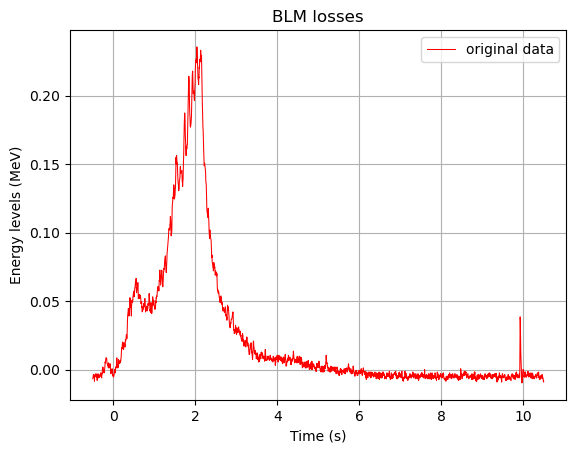

In [70]:

plt.plot(x_data, dataframe[DFI], color='red', linewidth=0.75, label = "original data")

plt.ylabel("Energy levels (MeV)")
plt.xlabel("Time (s)")
plt.title("BLM losses")

plt.legend()
plt.grid()
plt.show()

As you can see, there is a lot of noise in the data so it is hard to determine definite peaks, so we used a data filtering algorithm in order to filter out that noise. The algorithm we chose was the Savitzky-Golay filter for data smoothening.

In [65]:
windowLength = 190
polyorder = 0

The user can change the window_length and polyorder parameters to adjust the smoothening of the data.

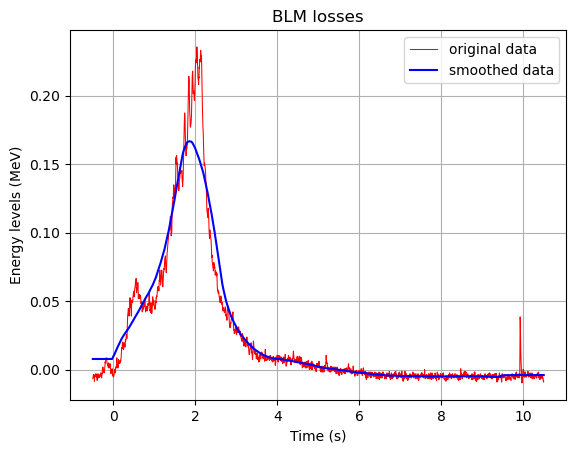

In [69]:
fig = plt.figure()
ax = fig.subplots()
ax.plot(x_data, dataframe[DFI], color='red', linewidth=0.75, label = "original data")

ax.plot(x_data, savgol_filter(dataframe[DFI], windowLength, polyorder), 'blue', label = "smoothed data")

plt.ylabel("Energy levels (MeV)")
plt.xlabel("Time (s)")
plt.title("BLM losses")

ax.legend()
ax.grid()
plt.show()

## Quantifying the magnitude of the peak

### Methods of quantifying

We started of by finding the maximum point of the peak and used it to find the full width half maximum, which we will use to find the area of the peak.

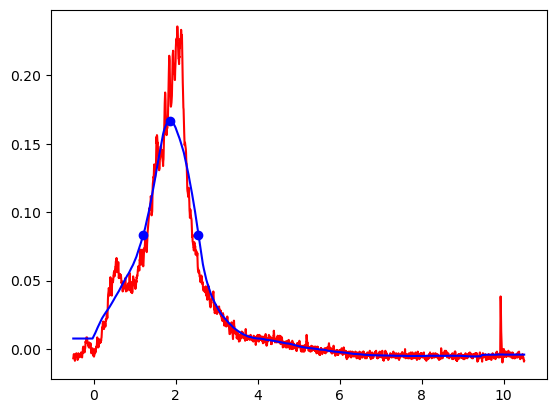

In [73]:
m, b = np.polyfit(x_data, dataframe[DFI], 1)

plt.plot(x_data, dataframe[DFI], 'r')
plt.plot(x_data, savgol_filter(dataframe[DFI], windowLength, polyOrder), 'b', label = "smoothed data")

threshold = 0.15
thresArray = []
residuals = []

for i in range(0, 2199):
    residuals.append(((savgol_filter(dataframe[DFI], windowLength, polyOrder))[i]))

for i in range(0, 2199):
    if residuals[i] > threshold:
        thresArray.append(residuals[i])

maxpeak = 0

for r in residuals:
    if r > maxpeak:
        maxpeak = r

plt.plot((residuals.index(maxpeak) * 11)/2200 - 0.5, (savgol_filter(dataframe[DFI], windowLength, polyOrder))[residuals.index(maxpeak)], 'bo')  

halfindices = []

sortedNearest = sorted(savgol_filter(dataframe[DFI], windowLength, polyOrder), key=lambda i: abs(i - (savgol_filter(dataframe[DFI], windowLength, polyOrder)[residuals.index(maxpeak)])/ 2))[:3]

plt.plot((residuals.index(sortedNearest[0]) * 11)/2200 - 0.5, (savgol_filter(dataframe[DFI], windowLength, polyOrder))[residuals.index(sortedNearest[0])], 'bo')
plt.plot((residuals.index(sortedNearest[1]) * 11)/2200 - 0.5, (savgol_filter(dataframe[DFI], windowLength, polyOrder))[residuals.index(sortedNearest[1])], 'bo')


### Method 1 - Calculating area of the peak using ...

In [80]:
time1 = ((residuals.index(sortedNearest[0]) * 11)/2200 - 0.5)
time2 = ((residuals.index(sortedNearest[1]) * 11)/2200 - 0.5)
(maxpeak)

print(time1) 
print(time2)

area = (time2  - time1) * maxpeak

print(f"{area} Micro Electro Volt MilliSeconds")

1.205
2.555
0.2250925340758344 Micro Electro Volt MilliSeconds


### Method 2 - Calculating area of the peak using integration

The area of a peak is proportional to the product of its height and its width, but the proportionality constant depends on the peak shape. 

Our method for finding the area under any peak is to find the area from the data values to the x-axis, the area from the baseline to the x-axis, and then take the difference between them.

In [88]:
smoothLine = savgol_filter(dataframe[DFI], windowLength, polyorder)
#peaks, info = find_peaks(smoothLine, width = 0)
np.trapz(smoothLine)

51.69077608041883

Useful videos:
- https://www.youtube.com/watch?v=wAmlfQqhCh0
- https://www.youtube.com/watch?v=eGnSmBb1nqw

Useful websites:
- https://numpy.org/doc/stable/reference/generated/numpy.trapz.html
- https://www.askpython.com/python-modules/numpy/numpy-trapz

## Next target ---> identifying multiple peaks